In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import math
import copy
import sklearn

In [ ]:
directory = "facebook100txt"
edge_list = []
node_list = []
plot_data_x = []
plot_data_y = []
diameter = []
network_size = []
geo_dist = []
largest_n = []
i = 0
for filename in os.listdir(directory):
    if not filename.endswith("_attr.txt"):
        print(i)
        print(filename)
        i += 1
        node_list = []
        with open(directory+"/"+filename.split(".txt")[0]+"_attr.txt", "r") as f:
            data = f.readline()
            data = f.readline()
            while data:
                vals = data.split("\n")[0].split("\t")
                node_list.append(int(vals[0]))
                data = f.readline()
        f.close()
        
        edge_list = []
        with open(directory+"/"+filename, "r") as f:
            data = f.readline()
            while data:
                vals = data.split("\n")[0].split("\t")
                edge_list.append((int(vals[0]), int(vals[1])))
                data = f.readline()
        f.close()
        
        G = nx.from_edgelist(edge_list)
        G.add_nodes_from(node_list)
        n = len(G.nodes)
        network_size.append(n)
        '''
        aveND = nx.average_neighbor_degree(G)
        MND = 0
        k = 0
        for val in aveND:
            MND += aveND[val]
            k += G.degree(val)
        MND /= n
        k /= n
        print(MND)
        print(k)
        plot_data_y.append(MND/k)
        plot_data_x.append(k)
        '''
        #graphs = list(nx.connected_component_subgraphs(G))
        #comp = list(nx.nx.connected_components(G))
        #print(comp)
        largest_cc = max(nx.connected_components(G), key=len)
        print(len(largest_cc))
        print(n)
        sub = G.subgraph(largest_cc)
        largest_n.append(len(largest_cc))
        #geo_dist.append(nx.average_shortest_path_length(sub))
        diameter.append(nx.diameter(sub))


0
American75.txt
6370
6387
1
Amherst41.txt
2235
2235
2
Auburn71.txt
18448
18449


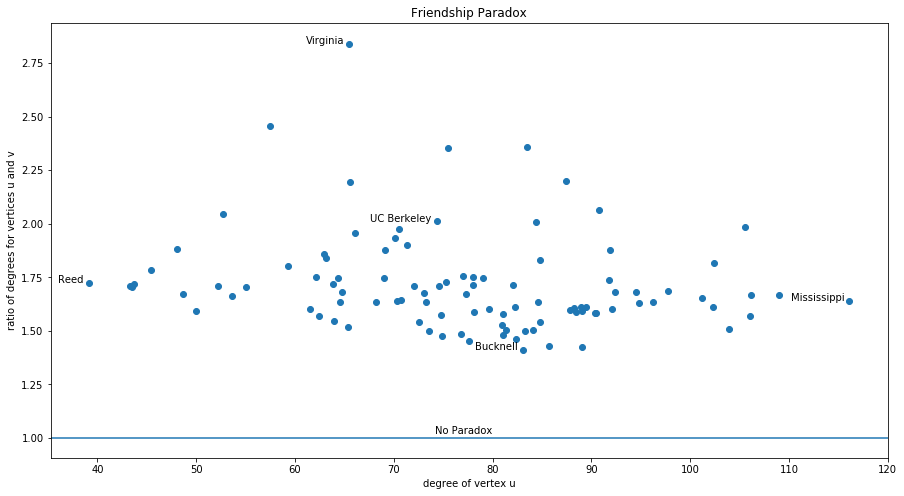

In [19]:
labels = (("Reed", 50), ("Bucknell", 11), ("Mississippi",37),
          ("Virginia", 91), ("UC Berkeley", 5) )
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(plot_data_x, plot_data_y)
ax.set_ylabel("ratio of degrees for vertices u and v")
ax.set_xlabel("degree of vertex u")
ax.set_title("Friendship Paradox")
ax.axhline(1)
ax.annotate("No Paradox", (80, 1.02),horizontalalignment='right')
for (txt, i) in labels:
    ax.annotate(txt, (plot_data_x[i]-0.5, plot_data_y[i]),horizontalalignment='right')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(network_size, diameter)
ax.set_ylabel("diameter")
ax.set_xlabel("network size")
ax.set_title("Network Diameter")

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(largest_n, geo_dist)
ax.set_ylabel("mean geodesic distance")
ax.set_xlabel("largest component size")
ax.set_title("Geodesic Distance")

In [3]:
def calcModularity(A, x, numTypes):
    n = len(A)
    m = np.sum(np.sum(A))
    # calculate e matrix
    e = [[0 for i in range(numTypes)] for j in range(numTypes)]
    for i in range(n):
        for j in range(n):
            if A[i][j]:
                u = x[i]
                v = x[j]
                e[u][v] += 1
    e = e / m
    # calculate a array
    a = np.sum(e, axis=1)
    # calculate modularity Q
    Q = 0
    for u in range(numTypes):
        Q += (e[u][u] - a[u]*a[u])
    return Q

In [27]:
#agglomeration algo
def greedyAgglomeration(A, groups, m):
    # separate the nodes into their own groups and 0 as the first delta Q
    if not groups:
        groups = []
        for i in range(len(A)):
            groups.append([i])
        q = [0]
        (arr, best) = greedyAgglomeration(A, groups, m)
        q.extend(arr)
        return (q, best)
    # if all the nodes are in one group, return an empty array
    if len(groups) == 1:
        return ([], groups)
    # maximum change in delta Q and indices of groups
    maxDeltaQ = -10**10
    indices = (-1,-1)
    # loop through pairs of groups
    for i in range(len(groups)):
        for j in range(i+1,len(groups)):
            # calculate av, au, and e for the two group
            e = 0
            av = 0
            for v in groups[i]:
                av += np.sum(A[v])
                au = 0
                for u in groups[j]:
                    e += A[v][u]
                    au = np.sum(A[u])
            e /= m
            # calculate the delta Q for the two groups, choose maximum
            deltaQ = 2*(e - (av/m)*(au/m))
            if maxDeltaQ < deltaQ:
                maxDeltaQ = deltaQ
                indices = (i, j)
    # combine the two groups from the maximum delta Q
    groups[indices[0]].extend(groups[indices[1]])
    groups.pop(indices[1])
    # extend the maximum delta Q by the recursive array of values and return
    q = [maxDeltaQ]
    c = copy.deepcopy(groups)
    (arr,best) = greedyAgglomeration(A, groups, m)
    q.extend(arr)
    if maxDeltaQ == max(q):
        return (q, c)
    return (q, best)

A = [[0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
     [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 1],
     [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
m = np.sum(A)/2

greedyAgglomeration(A,None,m)

([0,
  0.12244897959183673,
  0.12244897959183673,
  0.326530612244898,
  0.08163265306122452,
  -0.2857142857142857],
 [[0, 1], [2], [3, 4, 5]])

In [28]:
n = 34
A = np.array([[0 for i in range(n)] for j in range(n)])
edges = []
with open("karate_edges_77.txt", "r") as f:
    data = f.readline()
    while data:
        vals = data.split("\n")[0].split("\t")
        A[int(vals[0])-1][int(vals[1])-1] = 1
        edges.append((int(vals[0])-1,int(vals[1])-1))
        data = f.readline()
f.close()
print(A)
m = np.sum(A)/2

print(edges)
G = nx.Graph()
G.add_edges_from(edges)

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 0), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 0), (2, 1), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 0), (3, 1), (3, 2), (3, 7), (3, 12), (3, 13), (4, 0), (4, 6), (4, 10), (5, 0), (5, 6), (5, 10), (5, 16), (6, 0), (6, 4), (6, 5), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (8, 30), (8, 32), (8, 33), (9, 2), (9, 33), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (16, 5), (16, 6), (17, 0), (17, 1), (18, 32), (18, 33), (19, 0), (19, 1), (19, 33), (20, 32), (20, 33), (21, 0), (21, 1), (22, 32), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 3

In [30]:
(deltaQ, groups) = greedyAgglomeration(A, None, m)
print(deltaQ)

[0, 0.02327542587282847, 0.04385225164445944, 0.030359251138471918, 0.02563670096137629, 0.04857480182155506, 0.02327542587282847, 0.022938100860178785, 0.03980435149266318, 0.02192612582222972, 0.030359251138471918, 0.02192612582222972, 0.01990217574633159, 0.05093607691010288, 0.0195648507336819, 0.024962050936076913, 0.019227525721032215, 0.043514926631809746, 0.019227525721032215, 0.01889020070838253, 0.017878225670433463, 0.02293810086017878, 0.055321302074548835, 0.017540900657783777, 0.08466857817507167, 0.013830325518637209, 0.03440715129026817, -0.000674650025299376, -0.001349300050598752, 0.012818350480688148, -0.0030359251138471917, 0.015179625569235966, -0.0067465002529937595, 0.03811772642941472]


Text(0.5, 1.0, 'Modularity while Merging')

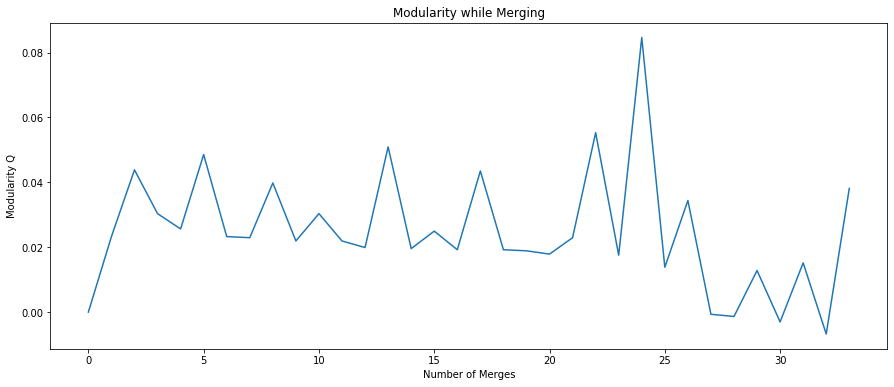

In [70]:
# line plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(range(0,len(deltaQ)), deltaQ)
ax.set_ylabel("Modularity Q")
ax.set_xlabel("Number of Merges")
ax.set_title("Modularity while Merging")

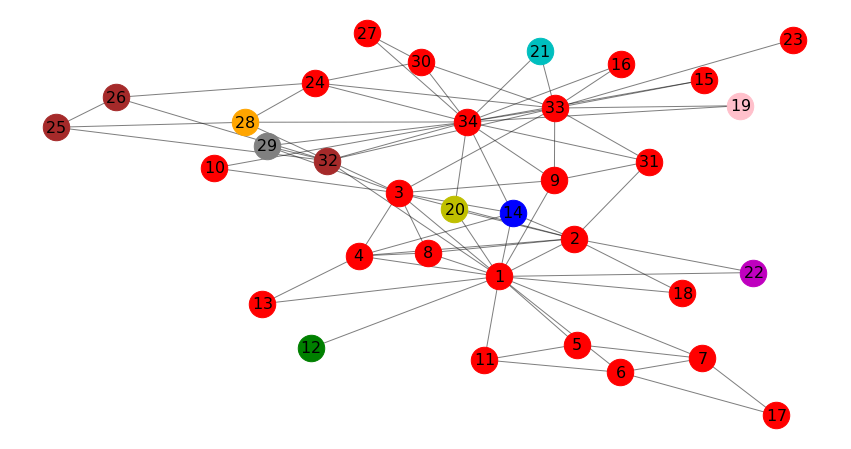

In [69]:
pos=nx.spring_layout(G) # positions for all nodes
fig, ax = plt.subplots(figsize=(15, 8))

# nodes
colors = ['r','g','b','#FFC0CB','y','c','m','#A52A2A','#FFA500','#808080']
for (group,color) in zip(groups,colors):
    nx.draw_networkx_nodes(G,pos,
                           nodelist=group,
                           node_color=color,
                           node_size=700)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels={}
for i in range(0,34):
    labels[i]=r'$'+str(i+1)+'$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

# some math labels
ax.axis('off')
#plt.savefig("labels_and_colors.png") # save as png
plt.show()

In [67]:
from sklearn.metrics.cluster import normalized_mutual_info_score
labels = [0 for i in range(34)]
j = 0
for group in groups:
    for i in group:
        labels[i] = j
    j += 1
social_labels = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
print(len(social_labels))
normalized_mutual_info_score(labels, social_labels, average_method='warn')

34


0.2415452287079647